# Capstone Project: Toronto Franchise Expansion

## Importing Required Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import folium

import geopy
from geopy.geocoders import Nominatim

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !pip install geopy # uncomment this line if you haven't completed the Foursquare API lab
# from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
# import folium # map rendering library

# Packages for web scrapping 
import requests
from bs4 import BeautifulSoup 

import urllib, json
import urllib.request

import geocoder

print('Libraries imported.')

Libraries imported.


## Getting the data

### New York Demographic Data

In [2]:
# Wipikepedia page URL for New York Demographics
def make_soup(url):
    thepage=urllib.request.urlopen(url)
    soupdata=BeautifulSoup(thepage, "html.parser")
    return soupdata

soup= make_soup("https://en.wikipedia.org/wiki/Demographics_of_New_York_City")
tableNYsaved=""
# find all table ,get the first
table = soup.find_all('table', class_="wikitable")[3]  # Only use the third table

NY_demo=pd.read_html(str(table))

# convert list to dataframe
NY_demo=pd.DataFrame(NY_demo[0])
NY_demo.columns = NY_demo.iloc[0]
NY_demo = NY_demo.drop(0)

# convert string data to numeric
NY_demo['2000 Census'] = NY_demo['2000 Census'].str.rstrip('%').astype('float') / 100.0

NY_demo.set_index('Age range', inplace=True)

NY_demo.head()

,2000 Census
Age range,
Under the age of 18,0.24
Between 18 and 24,0.10
Between 25 and 44,0.33
Between 45 and 64,0.21
Aged 65 or older,0.12


### Toronto Demographic Data

In [3]:
# Wipikepedia page URL for Toronto Demographics
def make_soup(url):
    thepage=urllib.request.urlopen(url)
    soupdata=BeautifulSoup(thepage, "html.parser")
    return soupdata

soup= make_soup("https://en.wikipedia.org/wiki/Demographics_of_Toronto")
tableNYsaved=""
# find all table ,get the first
table = soup.find_all('table', class_="wikitable")[1]  # Only use the third table

TO_demo=pd.read_html(str(table))
# convert list to dataframe
TO_demo=pd.DataFrame(TO_demo[0])
TO_demo = TO_demo.drop(["Male", "Female"], axis=1)

# Clean rows
i = TO_demo[((TO_demo['Age Groups'] == '0 to 14 years'))].index
TO_demo=TO_demo.drop(i)
y = TO_demo[((TO_demo['Age Groups'] == '15 to 64 years'))].index
TO_demo=TO_demo.drop(y)
z = TO_demo[((TO_demo['Age Groups'] == '65 to 85 years'))].index
TO_demo=TO_demo.drop(z)
x = TO_demo[((TO_demo['Age Groups'] == '85 years and over'))].index
TO_demo=TO_demo.drop(x)
a = TO_demo[((TO_demo['Age Groups'] == '100 years and over'))].index
TO_demo=TO_demo.drop(a)
TO_demo.head()

,Age Groups,Total
1,0 to 4 years,136000
2,5 to 9 years,135025
3,10 to 14 years,127105
5,15 to 19 years,145525
6,20 to 24 years,194750


In [4]:
# Clean age groups 
AfterSymbol = TO_demo['Age Groups'].str.split('to ').str[1]
TO_demo['Age']= AfterSymbol.str.split(' years').str[0]
TO_demo["Age"] = TO_demo["Age"].apply(pd.to_numeric)

conditions = [
    (TO_demo['Age'] <= 19),
    (TO_demo['Age'] > 19) & (TO_demo['Age'] <= 24),
    (TO_demo['Age'] > 24) & (TO_demo['Age'] <= 44),
    (TO_demo['Age'] > 44) & (TO_demo['Age'] <= 64),
    (TO_demo['Age'] > 64)
    ]

values = ['Under the age of 18', 'Between 18 and 24', 'Between 25 and 44', 'Between 45 and 64', 'Aged 65 or older']

TO_demo['Age_Group'] = np.select(conditions, values)

TO_demo.dropna(subset = ["Age_Group"], inplace=True)

TO_demo.head()


,Age Groups,Total,Age,Age_Group
1,0 to 4 years,136000,4,Under the age of 18
2,5 to 9 years,135025,9,Under the age of 18
3,10 to 14 years,127105,14,Under the age of 18
5,15 to 19 years,145525,19,Under the age of 18
6,20 to 24 years,194750,24,Between 18 and 24


In [7]:
# Find Age Group percentage over the total
TO_demo_groups = TO_demo.groupby(['Age_Group']).agg({'Total': 'sum'})
TO_demo_stats = TO_demo_groups.apply(lambda x: x / float(x.sum()))
TO_demo_stats.head()

,Total
Age_Group,
Aged 65 or older,0.156057
Between 18 and 24,0.071316
Between 25 and 44,0.306221
Between 45 and 64,0.267322
Under the age of 18,0.199083


### Toronto Neighborhoods

In [8]:
# Wipikepedia page URL
urlWiki = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

s = requests.Session()
response=s.get(urlWiki, timeout=10)

# parse response content to html
soup = BeautifulSoup(response.content, 'html.parser')

# get the table
wiki_table=soup.find('table', {"class":'wikitable sortable'})

df=pd.read_html(str(wiki_table))
# convert list to dataframe
df=pd.DataFrame(df[0])

# Drop rows that do not have a Borough
df.drop(df[df.Borough == 'Not assigned'].index, inplace=True)
df.reset_index(drop=True, inplace=True)

# Merge neighborhoods with the same Postal Code
Toronto = df.groupby('Postal Code', sort=False).agg( ','.join)
Toronto.reset_index(drop=False, inplace=True)

#Check if any neighborhood does not have a value
Toronto.loc[Toronto['Neighbourhood'] == 'Not assigned']

Toronto.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Toronto Geographic Data

In [9]:
# Preparing Address column for the Geocoder package
Toronto["Address"]=Toronto["Postal Code"]+", Toronto, Ontario"

# Reading CSV files with addresses
geoData = pd.read_csv('https://cocl.us/Geospatial_data')

Toronto = Toronto.drop('Address',axis=1)
Toronto=Toronto.merge(geoData, on='Postal Code', how='left')

Toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### New York Neighborhoods

In [10]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json"
response = urllib.request.urlopen(url)
newyork_data = json.loads(response.read())

neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
NY = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    NY = NY.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
NY.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


## Visualizing the Data

### Demographic Data

In [11]:
# Ensure all column titles are of type string
all(isinstance(column, str) for column in TO_demo.columns)
all(isinstance(column, str) for column in NY_demo.columns)

True

In [12]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.0


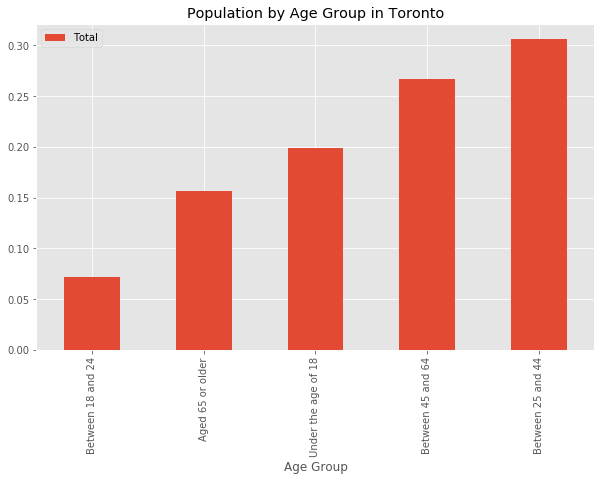

In [13]:
# plot Toronto demographic data
TO_demo_stats=TO_demo_stats.sort_values(by='Total', ascending=True)

TO_demo_stats.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Age Group') # add to x-label to the plot
plt.title('Population by Age Group in Toronto') # add title to the plot

plt.show()

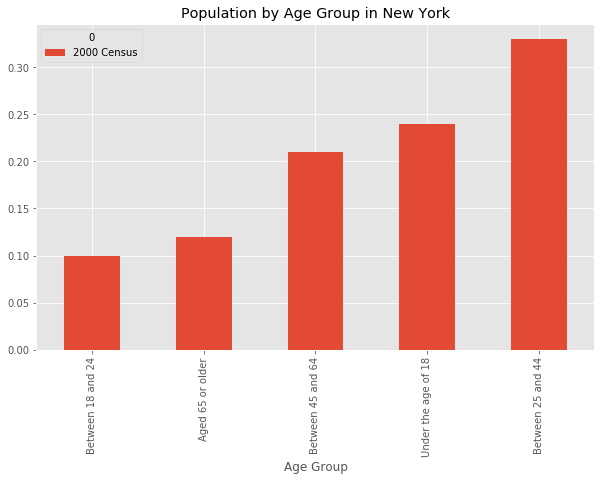

In [14]:
# plot Toronto demographic data
NY_demo=NY_demo.sort_values(by='2000 Census', ascending=True)

NY_demo.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Age Group') # add to x-label to the plot
plt.title('Population by Age Group in New York') # add title to the plot

plt.show()

### Toronto Neighborhoods

In [15]:
address = 'Toronto'

geolocator = Nominatim(user_agent="TO_explorer")
location_TO = geolocator.geocode(address)
latitude_TO = location_TO.latitude
longitude_TO = location_TO.longitude

# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude_TO, longitude_TO], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Toronto['Latitude'], Toronto['Longitude'], Toronto['Borough'], Toronto['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### New York Neighborhoods with Venues

In [16]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location_NY = geolocator.geocode(address)
latitude_NY = location_NY.latitude
longitude_NY = location_NY.longitude

# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude_NY, longitude_NY], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(NY['Latitude'], NY['Longitude'], NY['Borough'], NY['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

## Data Analysis

### Set up credentials for Foursquare API & Define function

In [17]:
CLIENT_ID = 'LJADP2S2YYYLXHSIPBBGDLYSVPK4QOT1C0LLCSUXLYZKVFOD' # your Foursquare ID
CLIENT_SECRET = 'KQ1QOCWCOGR11WKS10YTIGWAKFAQSPS5JLAVJF3BPUSKGFXI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LJADP2S2YYYLXHSIPBBGDLYSVPK4QOT1C0LLCSUXLYZKVFOD
CLIENT_SECRET:KQ1QOCWCOGR11WKS10YTIGWAKFAQSPS5JLAVJF3BPUSKGFXI


In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Main venue types for Toronto

In [19]:
toronto_venues = getNearbyVenues(names=Toronto['Neighbourhood'],
                                   latitudes=Toronto['Latitude'],
                                   longitudes=Toronto['Longitude']
                                  )
toronto_venues.head()

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena
3,Victoria Village,43.725882,-79.315572,Portugril,43.725819,-79.312785,Portuguese Restaurant
4,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop


In [20]:
print('There are {} uniques categories in Toronto.'.format(len(toronto_venues['Venue Category'].unique())))

There are 265 uniques categories in Toronto.


### Main venue types for New York

In [21]:
NY_venues = getNearbyVenues(names=NY['Neighborhood'],
                                   latitudes=NY['Latitude'],
                                   longitudes=NY['Longitude']
                                  )
NY_venues.head()

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


In [22]:
print('There are {} uniques categories in New York.'.format(len(NY_venues['Venue Category'].unique())))

There are 440 uniques categories in New York.


### Common clustering using k-Means

In [23]:
TOR = Toronto.drop(["Postal Code"], axis=1)
TOR["City"]="Toronto"
TOR=TOR.rename(columns={'Neighbourhood': 'Neighborhood'})
TOR.head()

,Borough,Neighborhood,Latitude,Longitude,City
0,North York,Parkwoods,43.753259,-79.329656,Toronto
1,North York,Victoria Village,43.725882,-79.315572,Toronto
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Toronto
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Toronto


In [24]:
# Prepare dataset for common clustering
NY["City"]="New York"
NY.head()

,Borough,Neighborhood,Latitude,Longitude,City
0,Bronx,Wakefield,40.894705,-73.847201,New York
1,Bronx,Co-op City,40.874294,-73.829939,New York
2,Bronx,Eastchester,40.887556,-73.827806,New York
3,Bronx,Fieldston,40.895437,-73.905643,New York
4,Bronx,Riverdale,40.890834,-73.912585,New York


In [25]:
CLU=TOR.append(NY, ignore_index=True)
CLU.head()

,Borough,Neighborhood,Latitude,Longitude,City
0,North York,Parkwoods,43.753259,-79.329656,Toronto
1,North York,Victoria Village,43.725882,-79.315572,Toronto
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Toronto
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Toronto


In [26]:
CLU_venues=toronto_venues.append(NY_venues, ignore_index=True)

In [27]:
# Preparing for Clustering
# one hot encoding
CLU_onehot = pd.get_dummies(CLU_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
CLU_onehot['Neighborhood'] = CLU_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [CLU_onehot.columns[-1]] + list(CLU_onehot.columns[:-1])
CLU_onehot = CLU_onehot[fixed_columns]

CLU_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cha Chaan Teng,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Hockey Field,Home Service,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Sta

In [29]:
CLU_grouped = CLU_onehot.groupby('Neighborhood').mean().reset_index()

In [30]:
# Define function for identifying top venues per neighborhood

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [31]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = CLU_grouped['Neighborhood']

for ind in np.arange(CLU_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(CLU_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Latin American Restaurant,Skating Rink,Breakfast Spot,Food Stand,Factory,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room
1,"Alderwood, Long Branch",Pizza Place,Pub,Pharmacy,Gym,Coffee Shop,Dance Studio,Sandwich Place,Exhibit,Event Space,Event Service
2,Allerton,Pizza Place,Supermarket,Chinese Restaurant,Bus Station,Dessert Shop,Donut Shop,Fast Food Restaurant,Pharmacy,Gas Station,Grocery Store
3,Annadale,Liquor Store,Pharmacy,Diner,Train Station,Food,Pizza Place,Dance Studio,Restaurant,Exhibit,Event Space
4,Arden Heights,Pizza Place,Pharmacy,Deli / Bodega,Coffee Shop,Bus Stop,Farm,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant


In [32]:
# Cluster Neighborhoods
# set number of clusters
kclusters = 10

CLU_grouped_clustering = CLU_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(CLU_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 0, 0, 0, 0, 2, 1, 4, 4, 4])

In [34]:
# add clustering labels
# neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop(["Cluster Labels"], axis=1)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

CLU_merged = CLU

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
CLU_merged = CLU_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

CLU_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,Toronto,5.0,Park,Food & Drink Shop,Women's Store,Farm,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
1,North York,Victoria Village,43.725882,-79.315572,Toronto,0.0,Pizza Place,Portuguese Restaurant,Coffee Shop,Hockey Arena,Farm,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Toronto,4.0,Coffee Shop,Bakery,Park,Theater,Breakfast Spot,Pub,Café,Bank,Event Space,Historic Site
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Toronto,4.0,Clothing Store,Furniture / Home Store,Miscellaneous Shop,Boutique,Coffee Shop,Vietnamese Restaurant,Event Space,Accessories Store,Ethiopian Restaurant,Event Service
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Toronto,4.0,Coffee Shop,Sushi Restaurant,Yoga Studio,Smoothie Shop,Bar,Gym,Beer Bar,Mexican Restaurant,Burger Joint,Burrito Place


In [35]:
CLU_merged = CLU_merged.dropna(subset=['Cluster Labels'])
CLU_merged['Cluster Labels'] = CLU_merged['Cluster Labels'].astype(int)

### Final Visualization

In [45]:
# create map
map_clusters = folium.Map(location=[latitude_TO, longitude_TO], zoom_start=6)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(CLU_merged['Latitude'], CLU_merged['Longitude'], CLU_merged['Neighborhood'], CLU_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Map focused on Toronto

In [46]:
TOR_f = CLU_merged[CLU_merged['City'] == "Toronto"]

# create map
TOR_clusters = folium.Map(location=[latitude_TO, longitude_TO], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(TOR_f['Latitude'], TOR_f['Longitude'], TOR_f['Neighborhood'], TOR_f['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(TOR_clusters)
       
TOR_clusters

#### Map focused on New York

In [47]:
NY_f = CLU_merged[CLU_merged['City'] == "New York"]

# create map
NY_clusters = folium.Map(location_NY=[latitude_NY, longitude_NY], zoom_start=50)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(NY_f['Latitude'], NY_f['Longitude'], NY_f['Neighborhood'], NY_f['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(NY_clusters)
       
NY_clusters

### Let's explore the most dominant cluster in Toronto's city center

In [49]:
CLU_merged.loc[CLU_merged['Cluster Labels'] == 4, CLU_merged.columns[[1] + list(range(5, CLU_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Regent Park, Harbourfront",4,Coffee Shop,Bakery,Park,Theater,Breakfast Spot,Pub,Café,Bank,Event Space,Historic Site
3,"Lawrence Manor, Lawrence Heights",4,Clothing Store,Furniture / Home Store,Miscellaneous Shop,Boutique,Coffee Shop,Vietnamese Restaurant,Event Space,Accessories Store,Ethiopian Restaurant,Event Service
4,"Queen's Park, Ontario Provincial Government",4,Coffee Shop,Sushi Restaurant,Yoga Studio,Smoothie Shop,Bar,Gym,Beer Bar,Mexican Restaurant,Burger Joint,Burrito Place
7,Don Mills,4,Gym,Beer Store,Restaurant,Japanese Restaurant,Coffee Shop,Chinese Restaurant,Asian Restaurant,Caribbean Restaurant,Supermarket,Art Gallery
9,"Garden District, Ryerson",4,Clothing Store,Coffee Shop,Café,Middle Eastern Restaurant,Japanese Restaurant,Italian Restaurant,Hotel,Bubble Tea Shop,Cosmetics Shop,Theater
11,"West Deane Park, Princess Gardens, Martin Grov...",4,Bakery,Women's Store,Farmers Market,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit
13,Don Mills,4,Gym,Beer Store,Restaurant,Japanese Restaurant,Coffee Shop,Chinese Restaurant,Asian Restaurant,Caribbean Restaurant,Supermarket,Art Gallery
15,St. James Town,4,Café,Coffee Shop,Cocktail Bar,Gastropub,American Restaurant,Hotel,Department Store,Cosmetics Shop,Restaurant,Farmers Market
18,"Guildwood, Morningside, West Hill",4,Breakfast Spot,Rental Car Location,Medical Center,Mexican Restaurant,Bank,Restaurant,Electronics Store,Intersection,Food,Flower Shop
19,The Beaches,4,Pub,Health Food Store,Trail,Duty-free Shop,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant
